In [ ]:
%%capture
!pip install mteb sentence-transformers

In [10]:
import torch
import mteb
from mteb import MTEB
from sentence_transformers import SentenceTransformer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
MODEL_NAME = "tomaarsen/mpnet-base-nli"
TASK_NAME = "STSBenchmark"
WINDOW_SIZE = 64  # The number of dimensions in each slice
STEP_SIZE = 16     # How many dimensions to slide the window forward each time
# For memory-constrained GPUs, you can reduce the batch size MTEB uses for encoding
ENCODE_BATCH_SIZE = 32

# --- A. The NEW Lightweight Model Wrapper ---
# This class does NOT load a model. It only wraps a pre-loaded model.
class ModelSliceWrapper:
    """
    A lightweight wrapper that uses a pre-loaded SentenceTransformer model
    to encode text and then returns a specific slice of the embeddings.
    """
    def __init__(self, main_model, start_dim: int, end_dim: int):
        self.main_model = main_model
        self.start_dim = start_dim
        self.end_dim = end_dim
        self.window_name = f"dims_{start_dim}-{end_dim}"

    def __getattr__(self, name):
        """
        This is a special Python method. If an attribute is not found on this
        wrapper object, it will automatically try to get it from self.main_model.
        This makes our wrapper transparent for accessing attributes like
        'model_card_data' that MTEB looks for.
        """
        print(f"--- Wrapper forwarding attribute request: {name} ---")
        return getattr(self.main_model, name)

    def encode(self, sentences, *args, **kwargs):
        """
        Uses the pre-loaded main model for the heavy lifting, then slices the result.
        """
        # Get the full embeddings from the single, pre-loaded model
        full_embeddings = self.main_model.encode(sentences, *args, **kwargs)

        # Return only the specified slice (the only job of this wrapper)
        return full_embeddings[:, self.start_dim:self.end_dim]

# --- B. The Main Evaluation Loop (Corrected for Memory Efficiency) ---

def run_sliding_window_evaluation():
    """
    Iterates through embedding dimensions, reusing a single loaded model
    to avoid CUDA out-of-memory errors.
    """
    # ### 1. LOAD THE MODEL ONLY ONCE ###
    # Load the base model onto the GPU *before* the loop starts.
    print(f"Loading base model '{MODEL_NAME}' onto GPU... This may take a moment.")
    try:
        # Check if CUDA is available and set the device
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {device}")
        main_model = SentenceTransformer(MODEL_NAME, device=device)
    except Exception as e:
        print(f"Failed to load model: {e}")
        return pd.DataFrame() # Return empty dataframe on failure

    total_dims = main_model.get_sentence_embedding_dimension()
    print(f"Model loaded. Total dimensions: {total_dims}.")

    # Get the MTEB task object
    evaluation_task = mteb.get_tasks(tasks=[TASK_NAME])
    results_list = []
    start_dim = 0

    print(f"\nStarting sliding window evaluation with Window Size={WINDOW_SIZE} and Step Size={STEP_SIZE}...")
    while start_dim + WINDOW_SIZE <= total_dims:
        end_dim = start_dim + WINDOW_SIZE
        window_label = f"{start_dim}-{end_dim}"
        print(f"--- Evaluating window: {window_label} ---")

        # ### 2. USE THE LIGHTWEIGHT WRAPPER ###
        # Create a cheap wrapper object that points to the main model.
        # This does NOT load a new model and uses virtually no GPU memory.
        slice_wrapper = ModelSliceWrapper(
            main_model=main_model,
            start_dim=start_dim,
            end_dim=end_dim
        )

        # 3. Configure and run the evaluation
        evaluator = MTEB(tasks=evaluation_task)
        results = evaluator.run(
            slice_wrapper,
            output_folder=f"results/{MODEL_NAME}/{slice_wrapper.window_name}",
            eval_splits=["test"],
            encode_kwargs={'batch_size': ENCODE_BATCH_SIZE} # Control MTEB's batch size
        )

        # 4. Extract and store the score
        try:
            spearman_score = results[0].scores["test"][0]["spearman"] * 100
            results_list.append({"window": window_label, "score": spearman_score})
            print(f"Result for {window_label}: Spearman = {spearman_score:.2f}")
        except (KeyError, IndexError) as e:
            print(f"Could not find Spearman score for window {window_label}. Error: {e}. Skipping.")

        # 5. Move the window forward
        start_dim += STEP_SIZE

    # ### 3. CLEAN UP ###
    # It's good practice to release the model from memory when done.
    print("\nEvaluation complete. Releasing model from memory.")
    del main_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return pd.DataFrame(results_list)

# --- C. Visualization (No changes needed here) ---
def plot_results(df):
    # ... (The plotting function from the previous answer is correct and unchanged)
    if df.empty:
        print("No results to plot.")
        return

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(16, 8))
    barplot = sns.barplot(x="window", y="score", data=df, palette="viridis")
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.1f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Embedding Dimension Window", fontsize=12)
    plt.ylabel("Spearman Correlation (%)", fontsize=12)
    plt.title(
        f"Performance of Embedding Segments on {TASK_NAME}\n"
        f"Model: {MODEL_NAME} | Window: {WINDOW_SIZE} dims | Step: {STEP_SIZE} dims",
        fontsize=16
    )
    plt.ylim(df['score'].min() * 0.9, df['score'].max() * 1.15)
    plt.tight_layout()
    output_filename = f"sts_sliding_window_eval_W{WINDOW_SIZE}_S{STEP_SIZE}.png"
    plt.savefig(output_filename)
    print(f"\nVisualization saved to '{output_filename}'")
    plt.show()

# # --- Run the entire process ---
# if __name__ == "__main__":
#     results_df = run_sliding_window_evaluation()
#     plot_results(results_df)

In [ ]:
results_df = run_sliding_window_evaluation()


/tmp/ipython-input-10-956955809.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x="window", y="score", data=df, palette="viridis")



Visualization saved to 'sts_sliding_window_eval_W64_S16.png'


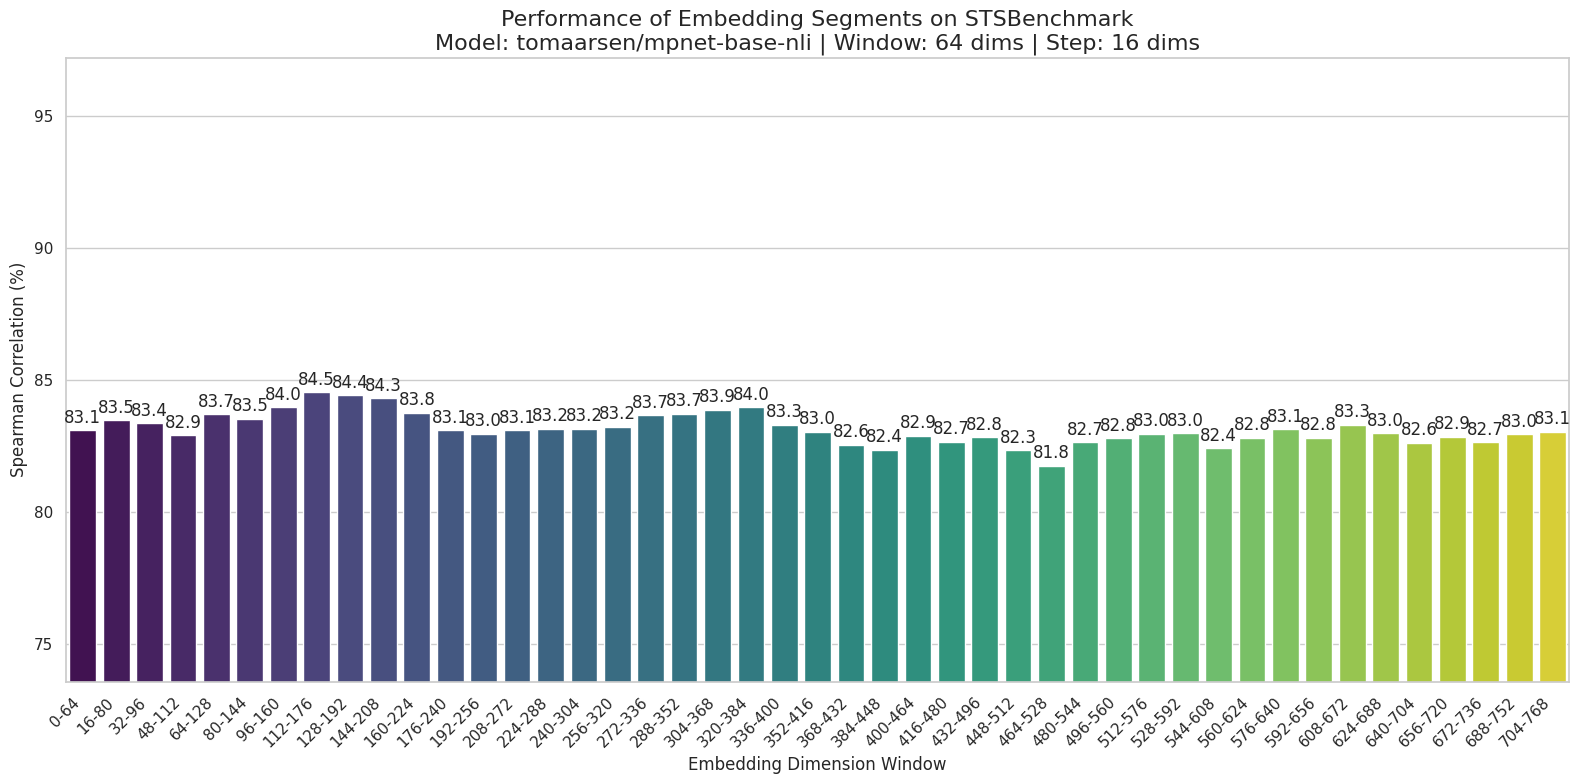

In [11]:
plot_results(results_df)

--------------------------------------------------
Performance Score Statistics
--------------------------------------------------
Max Performance (Spearman %): 84.55
Min Performance (Spearman %): 81.76
Mean Performance (Spearman %): 83.16
Standard Deviation:           0.57
--------------------------------------------------

Distribution plot saved to 'performance_distribution_plot.png'


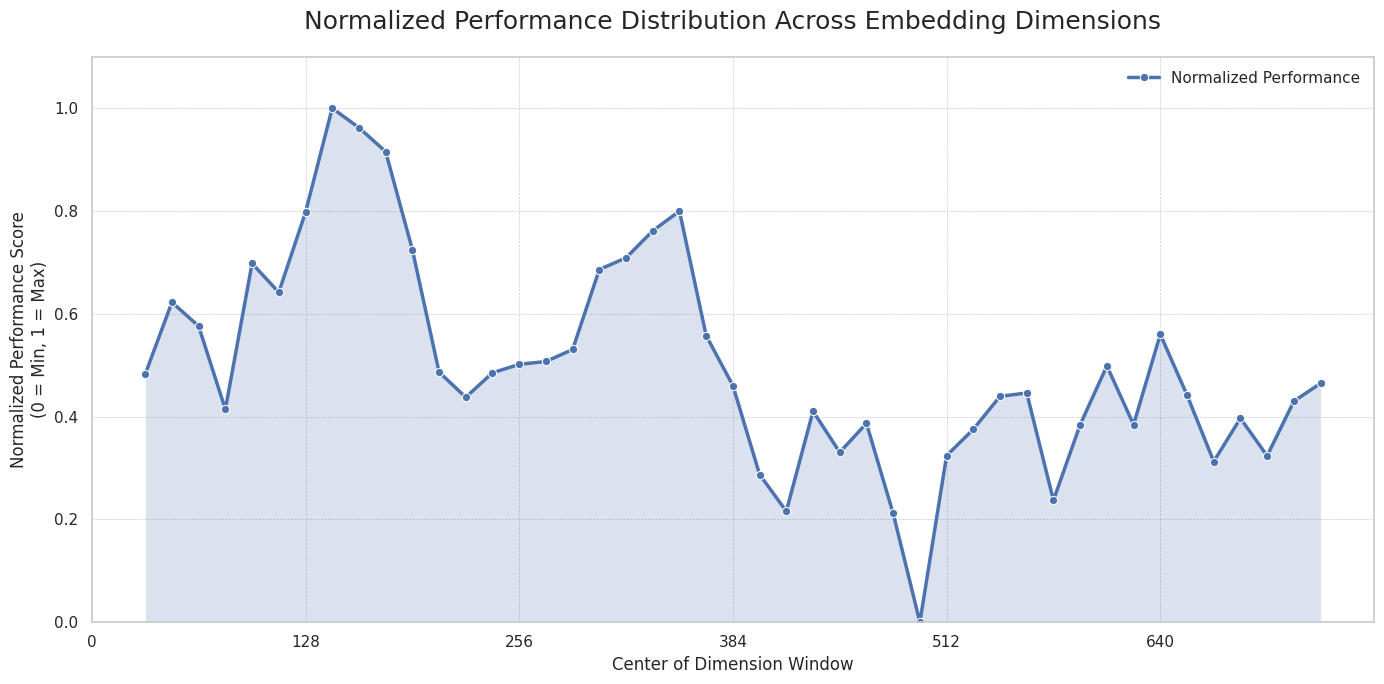

In [9]:
def analyze_and_visualize_distribution(df):
    """
    Calculates key statistics and creates a clean distribution plot of
    model performance across embedding dimensions.

    Args:
        df (pd.DataFrame): DataFrame with 'window' and 'score' columns.
    """
    if df.empty:
        print("DataFrame is empty. Cannot generate analysis.")
        return

    # --- 1. Calculate and Print Key Statistics ---
    print("-" * 50)
    print("Performance Score Statistics")
    print("-" * 50)
    max_score = df['score'].max()
    min_score = df['score'].min()
    mean_score = df['score'].mean()
    std_dev = df['score'].std()

    print(f"Max Performance (Spearman %): {max_score:.2f}")
    print(f"Min Performance (Spearman %): {min_score:.2f}")
    print(f"Mean Performance (Spearman %): {mean_score:.2f}")
    print(f"Standard Deviation:           {std_dev:.2f}")
    print("-" * 50)

    # --- 2. Prepare DataFrame for Plotting ---

    # Calculate the center of each window for the x-axis
    df[['start', 'end']] = df['window'].str.split('-', expand=True).astype(int)
    df['center_dim'] = (df['start'] + df['end']) / 2

    # Normalize the scores to a 0-1 range for the y-axis
    df['normalized_score'] = (df['score'] - min_score) / (max_score - min_score)

    # Sort by dimension for a clean line plot
    df = df.sort_values('center_dim').reset_index(drop=True)

    # --- 3. Create the Distribution Plot ---
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(14, 7))

    # Create the line plot
    ax = sns.lineplot(
        x='center_dim',
        y='normalized_score',
        data=df,
        marker='o', # Add markers for each actual window evaluation
        linewidth=2.5,
        label='Normalized Performance'
    )

    # Fill the area under the curve for a better visual feel
    plt.fill_between(df['center_dim'], df['normalized_score'], alpha=0.2)

    # --- 4. Customize and Show the Plot ---
    plt.title(f"Normalized Performance Distribution Across Embedding Dimensions", fontsize=18, pad=20)
    plt.xlabel("Center of Dimension Window", fontsize=12)
    plt.ylabel("Normalized Performance Score\n(0 = Min, 1 = Max)", fontsize=12)
    plt.xticks(np.arange(0, df['center_dim'].max() + 1, 128)) # Set x-ticks to be multiples of 128 for clarity
    plt.yticks(np.arange(0, 1.1, 0.2))
    plt.xlim(0, df['end'].max())
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Save the new plot
    output_filename = "performance_distribution_plot.png"
    plt.savefig(output_filename)
    print(f"\nDistribution plot saved to '{output_filename}'")

    plt.show()

# --- How to use it: ---
# Assuming 'results_df' is the DataFrame from your evaluation loop
# Just call the function with your DataFrame.
analyze_and_visualize_distribution(results_df)

In [15]:
def run_multi_split_sliding_window_evaluation():
    """
    Iterates through embedding dimensions and evaluates each window on
    ALL data splits (train, validation, test).
    """
    print(f"Loading base model '{MODEL_NAME}' onto GPU...")
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {device}")
        main_model = SentenceTransformer(MODEL_NAME, device=device)
    except Exception as e:
        print(f"Failed to load model: {e}")
        return pd.DataFrame()

    total_dims = main_model.get_sentence_embedding_dimension()
    print(f"Model loaded. Total dimensions: {total_dims}.")

    evaluation_task = mteb.get_tasks(tasks=[TASK_NAME])
    splits_to_run = ["test", "validation", "train"]
    results_list = []
    start_dim = 0

    print(f"\nStarting sliding window evaluation for splits: {splits_to_run}...")
    while start_dim + WINDOW_SIZE <= total_dims:
        end_dim = start_dim + WINDOW_SIZE
        window_label = f"{start_dim}-{end_dim}"
        print(f"--- Evaluating window: {window_label} ---")

        slice_wrapper = ModelSliceWrapper(
            main_model=main_model, start_dim=start_dim, end_dim=end_dim
        )
        evaluator = MTEB(tasks=evaluation_task)

        # This dictionary will hold scores for the current window across all splits
        window_scores = {"window": window_label}

        # Inner loop to run evaluation for each split
        for split in splits_to_run:
            print(f"  ...evaluating on '{split}' split")
            results = evaluator.run(
                slice_wrapper,
                eval_splits=[split], # Crucially, evaluate one split at a time
                output_folder=f"results/{MODEL_NAME}/{slice_wrapper.window_name}/{split}",
                encode_kwargs={'batch_size': ENCODE_BATCH_SIZE},
            )

            try:

                spearman_score = results[0].scores[split][0]["spearman"] * 100
                window_scores[f"{split}_score"] = spearman_score
            except (KeyError, IndexError):
                window_scores[f"{split}_score"] = None # Record failure as None
                print(f"    Could not find score for '{split}' split.")

        results_list.append(window_scores)
        start_dim += STEP_SIZE

    print("\nEvaluation complete. Releasing model from memory.")
    del main_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return pd.DataFrame(results_list)

In [16]:
def analyze_and_plot_split_comparison(df):
    """
    Analyzes the generalization of performance trends across data splits.
    Calculates correlation and plots a comparative line graph.

    Args:
        df (pd.DataFrame): DataFrame with 'window', 'test_score', 'validation_score', etc.
    """
    if df.empty or not all(col in df.columns for col in ['test_score', 'validation_score', 'train_score']):
        print("DataFrame is empty or missing required score columns. Cannot perform analysis.")
        return

    # --- 1. Quantitative Analysis: Correlation ---
    # Calculate the correlation between the performance trends of the splits.
    # A value close to 1.0 means the trends are very similar.
    print("-" * 60)
    print("Correlation of Performance Trends Across Splits")
    print("-" * 60)

    # Drop rows where any split failed, to ensure fair correlation calculation
    df_clean = df.dropna()

    corr_test_val = df_clean['test_score'].corr(df_clean['validation_score'])
    corr_test_train = df_clean['test_score'].corr(df_clean['train_score'])
    corr_val_train = df_clean['validation_score'].corr(df_clean['train_score'])

    print(f"Test vs. Validation Correlation: {corr_test_val:.4f}")
    print(f"Test vs. Train Correlation:      {corr_test_train:.4f}")
    print(f"Validation vs. Train Correlation: {corr_val_train:.4f}")
    print(" (A value > 0.8 indicates a strong positive correlation)")
    print("-" * 60)

    # --- 2. Data Preparation for Plotting ---
    df['center_dim'] = df['window'].str.split('-', expand=True).astype(int).mean(axis=1)

    # "Melt" the DataFrame from wide to long format for easier plotting with Seaborn
    long_df = df.melt(
        id_vars=['center_dim', 'window'],
        value_vars=['test_score', 'validation_score', 'train_score'],
        var_name='split',
        value_name='score'
    )
    long_df['split'] = long_df['split'].str.replace('_score', '') # Clean up names for the legend

    # --- 3. Visual Analysis: Comparative Plot ---
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(14, 8))

    # Use 'hue' to automatically create separate lines for each split
    sns.lineplot(
        data=long_df,
        x='center_dim',
        y='score',
        hue='split', # This is the key parameter for comparison
        marker='o',
        linewidth=2.5,
        palette='viridis' # Use a distinct color palette
    )

    plt.title("Performance Trend Comparison Across Data Splits", fontsize=18, pad=20)
    plt.xlabel("Center of Dimension Window", fontsize=12)
    plt.ylabel("Performance (Spearman Correlation %)", fontsize=12)
    plt.legend(title="Data Split")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    output_filename = "split_trend_comparison_plot.png"
    plt.savefig(output_filename)
    print(f"\nComparative plot saved to '{output_filename}'")
    plt.show()


Loading base model 'tomaarsen/mpnet-base-nli' onto GPU...
Using device: cuda
Model loaded. Total dimensions: 768.

Starting sliding window evaluation for splits: ['test', 'validation', 'train']...
--- Evaluating window: 0-64 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 16-80 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 32-96 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 48-112 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 64-128 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 80-144 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 96-160 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 112-176 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 128-192 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 144-208 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 160-224 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 176-240 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 192-256 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 208-272 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 224-288 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 240-304 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 256-320 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 272-336 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 288-352 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 304-368 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 320-384 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 336-400 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 352-416 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 368-432 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 384-448 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 400-464 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 416-480 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 432-496 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 448-512 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 464-528 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 480-544 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 496-560 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 512-576 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 528-592 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 544-608 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 560-624 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 576-640 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 592-656 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 608-672 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 624-688 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 640-704 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 656-720 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 672-736 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 688-752 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Evaluating window: 704-768 ---
  ...evaluating on 'test' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'validation' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---
  ...evaluating on 'train' split
--- Wrapper forwarding attribute request: mteb_model_meta ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: model_card_data ---
--- Wrapper forwarding attribute request: similarity_fn_name ---


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

--- Wrapper forwarding attribute request: similarity_pairwise ---
--- Wrapper forwarding attribute request: similarity_pairwise ---

Evaluation complete. Releasing model from memory.
------------------------------------------------------------
Correlation of Performance Trends Across Splits
------------------------------------------------------------
Test vs. Validation Correlation: 0.4799
Test vs. Train Correlation:      0.7872
Validation vs. Train Correlation: 0.6590
 (A value > 0.8 indicates a strong positive correlation)
------------------------------------------------------------

Comparative plot saved to 'split_trend_comparison_plot.png'


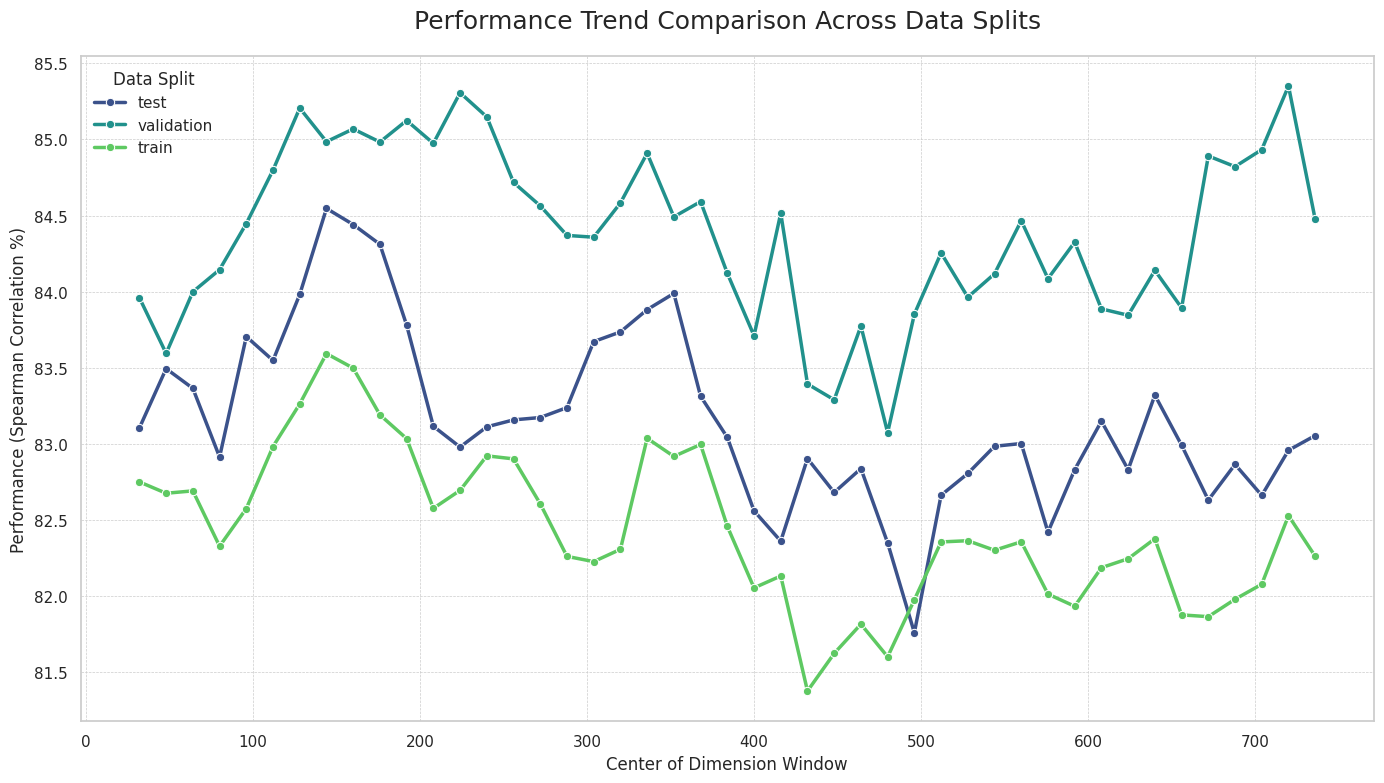

In [17]:
multi_split_df = run_multi_split_sliding_window_evaluation()

# 2. Run the new analysis and visualization function
if not multi_split_df.empty:
    analyze_and_plot_split_comparison(multi_split_df)